# Solve the Robertson Equations
Solve the Robertson Equations using Explicit methods
These equations are a stiff system, and so explicit methods can have trouble integrating.

Robertson Equations:
$
\frac{dx}{dt} = -0.04x + 10000yz \\
\frac{dy}{dt} = 0.04x - 10000yz - 30000000y^2 \\
\frac{dz}{dt} = 30000000y^2
$

In [ ]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
import rungekutta as rk
import numpy as np
import pandas as pd
from plotnine import *
import time
import matplotlib.pylab as plt

In [ ]:
def robertson_rhs(y, t):
    return np.array([\
        -0.04 * y[0] + 10000 * y[1] * y[2],
        0.04 * y[0] - 10000 * y[1] * y[2] - 30000000 * y[1] * y[1],
        30000000 * y[1] * y[1]
    ], dtype=float)

In [ ]:
solvers = {
    'forward_euler': rk.forward_euler(),
    'explicit_midpoint': rk.explicit_midpoint(),
    'fourth_order_runge_kutta': rk.fourth_order_runge_kutta(),
    'dormand_prince': rk.dormand_prince()}
for s in solvers: solvers[s].set_func(robertson_rhs)

## Solve using each of the Solvers with different step_sizes

In [91]:
df_results = pd.DataFrame()
df_performance = pd.DataFrame()
step_sizes = [0.0001]
times = np.linspace(0, 100, 100)


def solve(solver, step_size):
    print(f'\rSolving using {solver} with step size: {step_size:.1e}' + ' '*50, end='')
    t0 = time.perf_counter()
    y = solvers[solver].solve_times(times, y0=[1, 0, 0], t0=0, step_size=step_size)
    t1 = time.perf_counter()

    global df_results
    global df_performance
    for ti, xi, yi, zi in zip(times, y[:, 0], y[:, 1], y[:, 2]): df_results = df_results.append({'t': ti, 'x': xi, 'y': yi, 'z': yi, 'method': solver, 'step_size': str(step_size)}, ignore_index=True)
    df_performance = df_performance.append({'step_size': step_size, 'method': solver, 'time': t1-t0}, ignore_index=True)

for s in [1e-4, 2e-4, 5e-4]: solve('dormand_prince', s)
for s in [1e-4, 2e-4, 5e-4]: solve('fourth_order_runge_kutta', s)
for s in [5e-5, 1e-4, 2e-4, 5e-4]: solve('explicit_midpoint', s)
for s in [5e-5, 1e-4, 2e-4]: solve('forward_euler', s)

Solving using forward_euler with step size: 2.0e-04                                                             

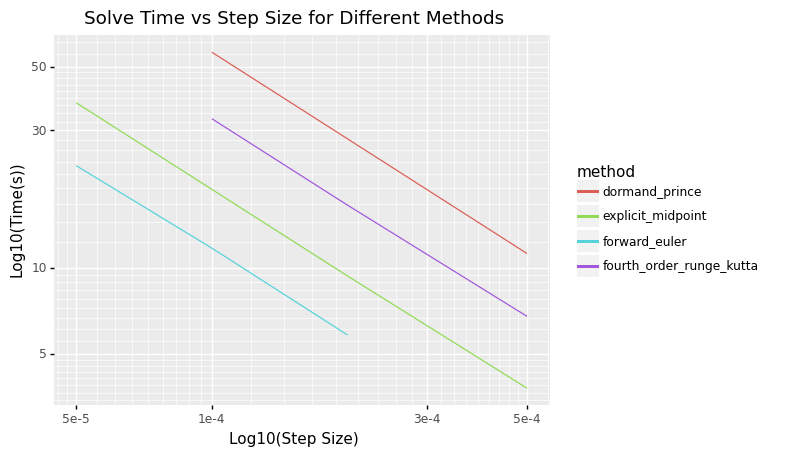

<ggplot: (8788690892373)>

In [96]:
(
    ggplot(df_performance, aes(x='step_size', y='time')) +
    geom_line(aes(group='method', color='method')) +
    scale_x_log10() + scale_y_log10() +
    ggtitle('Solve Time vs Step Size for Different Methods') +
    xlab('Log10(Step Size)') + ylab('Log10(Time(s))')
)

## Compare these solutions to scipy.integrate.odeint

In [97]:
import scipy.integrate

class ScipyComparator:
    def __init__(self, function, initial, times):
        self.truth = scipy.integrate.odeint(robertson_rhs, [1, 0, 0], times)
    
    def error(self, other, j=0):
        error = 0
        for i in range(other.shape[0]):
            error += (other[i] - self.truth[i, j])*(other[i]-self.truth[i, j])
        return np.sqrt(error / other.shape[0])
compare = ScipyComparator(robertson_rhs, [1,0,0], times)

df_errors = pd.DataFrame(columns=('method', 'step_size', 'x_rms_error', 'y_rms_error', 'z_rms_error', 'avg_rms_error'))
index = pd.MultiIndex.from_frame(df_results[["method", "step_size"]])
df_grouped = df_results.set_index(index)
for i in index.unique():
    x_err = compare.error(df_grouped.loc[i]["x"], 0)
    y_err = compare.error(df_grouped.loc[i]["y"], 1)
    z_err = compare.error(df_grouped.loc[i]["z"], 2)
    df_errors = df_errors.append({
        'method': i[0], 'step_size': float(i[1]), 'x_rms_error': x_err, 'y_rms_error': y_err, 'z_rms_error': z_err, 'avg_rms_error':(u_err+v_err+z_err)/3}, ignore_index=True)

/tmp/ipykernel_4357/4003144392.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/tmp/ipykernel_4357/4003144392.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
/tmp/ipykernel_4357/4003144392.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.


In [98]:
df_errors

,method,step_size,x_rms_error,y_rms_error,z_rms_error,avg_rms_error
0,dormand_prince,0.00010,5.044255e-07,6.955868e-11,0.295802,0.098601
1,dormand_prince,0.00020,7.841198e-07,9.611158e-11,0.295802,0.098601
2,dormand_prince,0.00050,1.827931e-06,2.253946e-10,0.295802,0.098601
3,fourth_order_runge_kutta,0.00010,5.044255e-07,6.955868e-11,0.295802,0.098601
4,fourth_order_runge_kutta,0.00020,7.841198e-07,9.611158e-11,0.295802,0.098601
5,fourth_order_runge_kutta,0.00050,1.827933e-06,2.253945e-10,0.295802,0.098601
6,explicit_midpoint,0.00005,2.337548e-07,4.434686e-11,0.295802,0.098601
7,explicit_midpoint,0.00010,5.044248e-07,6.955858e-11,0.295802,0.098601
8,explicit_midpoint,0.00020,7.841170e-07,9.611113e-11,0.295802,0.098601
9,explicit_midpoint,0.00050,2.737849e-04,1.801438e-06,0.295803,0.098601


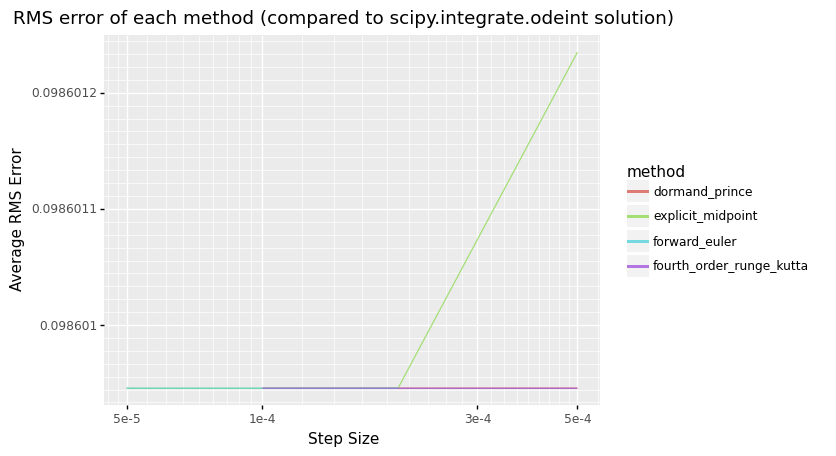

<ggplot: (8788691198730)>

In [131]:
(
    ggplot(df_errors, aes(x='step_size')) +
    geom_line(aes(y='avg_rms_error', colour='method'), alpha=0.8) +
    scale_x_log10() + scale_y_log10() +
    ggtitle("RMS error of each method (compared to scipy.integrate.odeint solution)") +
    ylab('Average RMS Error') + xlab('Step Size')
)

Without Explicit Midpoint Method

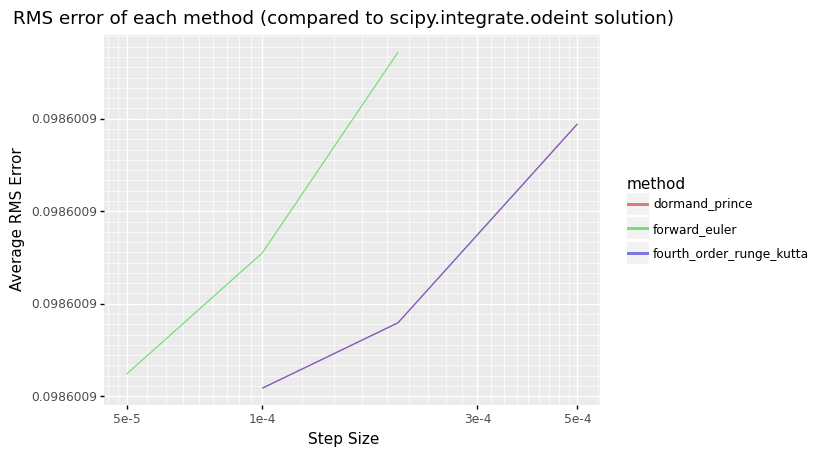

<ggplot: (8788696122908)>

In [132]:
(
    ggplot(df_errors.query('method!="explicit_midpoint"'), aes(x='step_size')) +
    geom_line(aes(y='avg_rms_error', colour='method'), alpha=0.8) +
    scale_x_log10() + scale_y_log10() +
    ggtitle("RMS error of each method (compared to scipy.integrate.odeint solution)") +
    ylab('Average RMS Error') + xlab('Step Size')
)

dormand_prince and fourth_order_runge_kutta are on top of each other